In [1]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,108 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,477 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

#  SparkSession
spark = SparkSession.builder.appName("Tarea5").getOrCreate()

# Cargar el dataset
df = spark.read.csv("/Movies_clean.csv", header=True, inferSchema=True)

In [3]:
from pyspark.sql import functions as F

# Vistazo de las primeras filas
df.show(5)

+--------+---------------+------------+----------+------+------------+----------+-----+---------+---------+-----------------+---------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+----+
|movie_id|          title|vote_average|vote_count|status|release_date|   revenue|adult|   budget|  imdb_id|original_language| original_title|            overview|popularity|              genres|production_companies|production_countries|    spoken_languages| año|
+--------+---------------+------------+----------+------+------------+----------+-----+---------+---------+-----------------+---------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+----+
| 4520010|      Inception|       8.364|     34495|     1|  15/07/2010| 825532764|    0|160000000|tt1375666|               en|      Inception|\Cobb a skilled t...|      NULL|                NULL|                N

Analisis de variables

In [4]:
#estadisticas de algunas variables numéricas

df.select("vote_average").describe().show()
df.select("vote_count").describe().show()
df.select("revenue").describe().show()
df.select("budget").describe().show()

+-------+------------------+
|summary|      vote_average|
+-------+------------------+
|  count|            108584|
|   mean| 6.002334920430293|
| stddev|1.1228891882012229|
|    min|               0.5|
|    max|              10.0|
+-------+------------------+

+-------+------------------+
|summary|        vote_count|
+-------+------------------+
|  count|            108584|
|   mean|190.07624511898624|
| stddev| 1014.350666339881|
|    min|                 3|
|    max|             34495|
+-------+------------------+

+-------+--------------------+
|summary|             revenue|
+-------+--------------------+
|  count|              108584|
|   mean|    6504949.26688094|
| stddev|5.1492443793638326E7|
|    min|                   0|
|    max|          2923706026|
+-------+--------------------+

+-------+--------------------+
|summary|              budget|
+-------+--------------------+
|  count|              108584|
|   mean|   2436930.343540485|
| stddev|1.3609173030540757E7|
|    min| 

In [5]:
#buscar valores nulos y limpiar

null_counts = df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns])

null_counts.show()

df_clean = df.dropna() #Borrar filas con valores nulos

null_counts = df_clean.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df_clean.columns])

null_counts.show()

+--------+-----+------------+----------+------+------------+-------+-----+------+-------+-----------------+--------------+--------+----------+------+--------------------+--------------------+----------------+----+
|movie_id|title|vote_average|vote_count|status|release_date|revenue|adult|budget|imdb_id|original_language|original_title|overview|popularity|genres|production_companies|production_countries|spoken_languages| año|
+--------+-----+------------+----------+------+------------+-------+-----+------+-------+-----------------+--------------+--------+----------+------+--------------------+--------------------+----------------+----+
|       0|    0|          25|        25|    25|          25|     25|   25|    25|     25|               25|            25|      33|      8467|  8467|                8467|                8661|            8661|8661|
+--------+-----+------------+----------+------+------------+-------+-----+------+-------+-----------------+--------------+--------+----------+--

Analisis predictivo

In [6]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

#Filtrar columnas con valores numéricos

df1 = df_clean.drop("movie_id", "title","release_date",
                      "original_language","original_title",
                      "overview","genres", "production_companies","production_countries"
                      "spoken_languages", "adult", "status", "vote_count", "imdb_id",
                      "production_countries", "spoken_languages", "año" )
df1.show(5)

+------------+----------+---------+----------+
|vote_average|   revenue|   budget|popularity|
+------------+----------+---------+----------+
|       8.417| 701729206|165000000|   140.241|
|       8.512|1004558444|185000000|   130.643|
|       7.573|2923706026|237000000|    79.932|
|        7.71|1518815515|220000000|    98.082|
|       7.606| 783100000| 58000000|    72.735|
+------------+----------+---------+----------+
only showing top 5 rows



Predecir ganancias mediante regresión

In [7]:
from pyspark.ml.regression import LinearRegression


assembler = VectorAssembler(
    inputCols=["vote_average", "budget", "popularity"],
    outputCol="features"
)

In [8]:
lr = LinearRegression(featuresCol="features", labelCol="revenue")
pipeline  = Pipeline(stages=[assembler, lr]) #Ensamble de características y modelo

train, test = df1.randomSplit([0.7, 0.3], seed = 1) #División en entrenamiento y prueba
model = pipeline.fit(train) #Entrenar el modelo

# Predicciones
pred = model.transform(test)
pred.select("prediction", "revenue","features").show()

+-------------------+-------+--------------------+
|         prediction|revenue|            features|
+-------------------+-------+--------------------+
|-7653868.9835540755|      0|     [1.4,0.0,2.863]|
| -7600294.502077731|      0|   [1.467,0.0,2.479]|
| -5828640.563280217|5000000|  [1.821,0.0,12.955]|
| -5155863.770118317|2800000|[1.84,500000.0,6....|
|  -7055930.33402593|      0|   [1.857,0.0,2.197]|
| -7004232.540247287|      0|     [1.9,0.0,2.096]|
| -6994947.382790588|      0|     [1.9,0.0,2.174]|
| -6734502.241307881|      0|   [2.058,0.0,2.395]|
| -5797976.892434112|      0|[2.098,10000.0,9....|
| -6749639.552150033|      0|     [2.1,0.0,1.745]|
| -6733926.208761774|      0|     [2.1,0.0,1.877]|
| -6794907.289682491|      0|   [2.115,0.0,1.178]|
| -6730177.228431752|      0|   [2.139,0.0,1.423]|
| -6622001.786968252|    200|   [2.154,0.0,2.145]|
| -6472683.879597923|      0|   [2.157,0.0,3.362]|
| -6377179.189100496|      0|     [2.2,0.0,3.629]|
| -6041585.050963482|      0|[2

Evaluación

In [9]:
from pyspark.ml.evaluation import RegressionEvaluator

eval = RegressionEvaluator(labelCol="revenue", predictionCol="prediction", metricName="rmse")
rmse = eval.evaluate(pred)
print("RMSE:", rmse) #imprimir razi del error cuadrado medio

RMSE: 31357704.586860254


Predecir popularidad

In [10]:
assembler = VectorAssembler(
    inputCols=["vote_average", "budget", "revenue"],
    outputCol="features"
)

features_df = assembler.transform(df1)
features_df.show(5)

+------------+----------+---------+----------+--------------------+
|vote_average|   revenue|   budget|popularity|            features|
+------------+----------+---------+----------+--------------------+
|       8.417| 701729206|165000000|   140.241|[8.417,1.65E8,7.0...|
|       8.512|1004558444|185000000|   130.643|[8.512,1.85E8,1.0...|
|       7.573|2923706026|237000000|    79.932|[7.573,2.37E8,2.9...|
|        7.71|1518815515|220000000|    98.082|[7.71,2.2E8,1.518...|
|       7.606| 783100000| 58000000|    72.735|[7.606,5.8E7,7.83...|
+------------+----------+---------+----------+--------------------+
only showing top 5 rows



In [11]:
#regresión
train1, test1 = features_df.randomSplit([0.7, 0.3], seed = 1)
lr = LinearRegression(featuresCol="features", labelCol="popularity")
model1 = lr.fit(train1)

lr_pred = model1.transform(test1)
lr_pred.select("prediction", "popularity", "features").show()

+--------------------+----------+--------------------+
|          prediction|popularity|            features|
+--------------------+----------+--------------------+
| -1.2265833287271686|     2.863|       [1.4,0.0,0.0]|
|  -1.139397793680265|     2.479|     [1.467,0.0,0.0]|
| -0.4594323212674114|    12.955|[1.821,0.0,500000...|
| -0.3690969426837487|     6.203|[1.84,500000.0,28...|
| -0.6318999031087396|     2.197|     [1.857,0.0,0.0]|
| -0.5759450074816228|     2.096|       [1.9,0.0,0.0]|
| -0.5759450074816228|     2.174|       [1.9,0.0,0.0]|
|-0.37034329796803034|     2.395|     [2.058,0.0,0.0]|
|-0.31505005066031533|     9.521| [2.098,10000.0,0.0]|
|-0.31568967898340405|     1.745|       [2.1,0.0,0.0]|
|-0.31568967898340405|     1.877|       [2.1,0.0,0.0]|
| -0.2961705293460377|     1.178|     [2.115,0.0,0.0]|
|-0.26493988992625184|     1.423|     [2.139,0.0,0.0]|
| -0.2454119677472466|     2.145|   [2.154,0.0,200.0]|
|-0.24151691036141187|     3.362|     [2.157,0.0,0.0]|
|-0.185562

In [12]:
#Evaluación del modelo
eval = RegressionEvaluator(labelCol="popularity", predictionCol="prediction", metricName="rmse")
rmse = eval.evaluate(lr_pred)
print("RMSE:", rmse)

RMSE: 22.714261912394793


Cluster

In [13]:
from pyspark.ml.clustering import KMeans

assembler = VectorAssembler(
    inputCols=["vote_average", "budget", "popularity", "revenue"],
    outputCol="features"
)

df_feat = assembler.transform(df1)


In [14]:
#Crear modelo
kmeans = KMeans(k=3, seed=1)
model = kmeans.fit(df_feat)
cluster = model.transform(df_feat)
cluster.show(5)

+------------+----------+---------+----------+--------------------+----------+
|vote_average|   revenue|   budget|popularity|            features|prediction|
+------------+----------+---------+----------+--------------------+----------+
|       8.417| 701729206|165000000|   140.241|[8.417,1.65E8,140...|         1|
|       8.512|1004558444|185000000|   130.643|[8.512,1.85E8,130...|         1|
|       7.573|2923706026|237000000|    79.932|[7.573,2.37E8,79....|         1|
|        7.71|1518815515|220000000|    98.082|[7.71,2.2E8,98.08...|         1|
|       7.606| 783100000| 58000000|    72.735|[7.606,5.8E7,72.7...|         1|
+------------+----------+---------+----------+--------------------+----------+
only showing top 5 rows



In [15]:
# resultado

centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[5.99049703e+00 1.37172366e+06 5.21714480e+00 2.02747415e+06]
[7.19814973e+00 1.60652416e+08 8.65187968e+01 9.15850783e+08]
[6.71882152e+00 6.93507031e+07 4.42491548e+01 2.45646853e+08]


Visualización con PCE

In [16]:
from pyspark.ml.feature import PCA

# agrupación
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(df_feat)
result = model.transform(df_feat)

result.show(5)

+------------+----------+---------+----------+--------------------+--------------------+
|vote_average|   revenue|   budget|popularity|            features|         pcaFeatures|
+------------+----------+---------+----------+--------------------+--------------------+
|       8.417| 701729206|165000000|   140.241|[8.417,1.65E8,140...|[-7.2058572731468...|
|       8.512|1004558444|185000000|   130.643|[8.512,1.85E8,130...|[-1.0212282896579...|
|       7.573|2923706026|237000000|    79.932|[7.573,2.37E8,79....|[-2.9114471795484...|
|        7.71|1518815515|220000000|    98.082|[7.71,2.2E8,98.08...|[-1.5319809841827...|
|       7.606| 783100000| 58000000|    72.735|[7.606,5.8E7,72.7...|[-7.7871178515758...|
+------------+----------+---------+----------+--------------------+--------------------+
only showing top 5 rows



In [17]:
#Combinar PCA con las predicciones del cluster
pca_cluster = result.join(cluster.select("features", "prediction"), on="features")

In [18]:
# convertir a pandas
import pandas as pd
pca_cluster_pd = pca_cluster.select("pcaFeatures", "prediction").toPandas()

In [19]:
pca_cluster_pd.head()

,pcaFeatures,prediction
0,"[-720585727.3146845, -20126801.62804401]",1
1,"[-1021228289.657989, 21341223.34677523]",1
2,"[-2911447179.5484667, 357353112.716241]",1
3,"[-1531980984.182758, 90745979.01368578]",1
4,"[-778711785.1575801, 101081974.93470363]",1


In [21]:
pca_cluster_pd['x'] = pca_cluster_pd['pcaFeatures'].apply(lambda x: x[0])
pca_cluster_pd['y'] = pca_cluster_pd['pcaFeatures'].apply(lambda x: x[1])

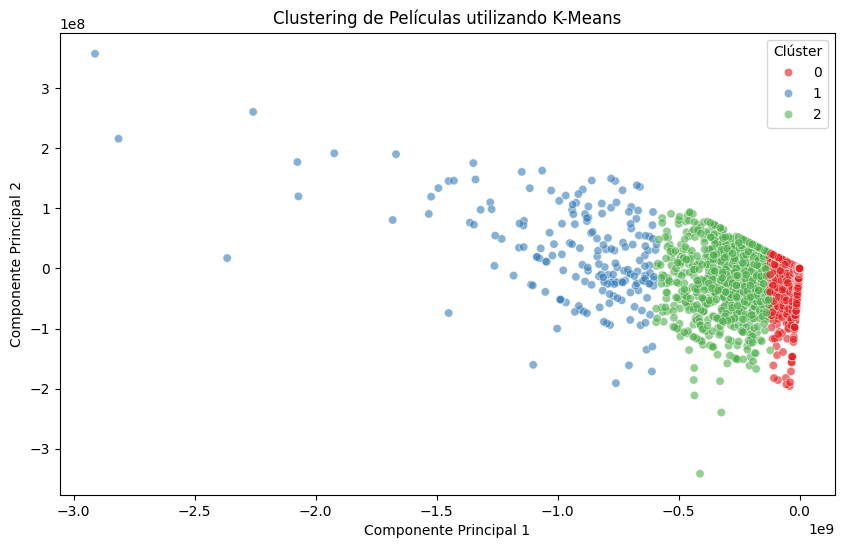

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_cluster_pd, x='x', y='y', hue='prediction', palette='Set1', alpha=0.6)
plt.title("Clustering de Películas utilizando K-Means")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title='Clúster')
plt.show()